In [1]:
import os 
import sys
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import functools
import time 

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

sys.path.append("../src")
from kernel import *
from kernelized_pegasos import * 
from kernelized_ridge import * 

%matplotlib inline
import seaborn as sns


In [2]:
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = (13,10)

# Problem 2

The kernel matrix is given by $K = XX^T \in \mathbf{R}^{n\times n}$. Explicitly in terms of training vectors it's given by 

$$ K = 
\begin{bmatrix}
x_1^Tx_1 & x_1^Tx_2 & \cdots & x_1^Tx_n\\
x_2^Tx_1 & x_2^Tx_2 & \cdots & x_2^Tx_n\\
\vdots & \vdots & \ddots & \vdots\\
x_n^Tx_1 & x_n^Tx_2 & \cdots & x_n^Tx_n^T
\end{bmatrix}
$$

The squared Euclidean distance between two vectors is given by $d(x,y) = ||x_i-x_j||^2 = ||x_i||^2 + ||x_j||^2 - 2x_i^Tx_j$. It's clear the Gram matrix contains all the information needed to compute the pairwise distances between training examples.

# Problem 3

Consider the regularized least squares objective

$$J(w) = ||Xw-y||^2+ \lambda ||w||^2$$
where $\lambda > 0$

This problem can be written as an ordinary least squres problem of the form $\min ||Aw - b||^2$ where 

$$ 
A = \begin{bmatrix}
X\\
\sqrt{\lambda} I
\end{bmatrix},
b=
\begin{bmatrix}
y \\
0
\end{bmatrix}
$$

This is easily solved as 
$$
\begin{align*}
w^\star &= (A^TA)^{-1}A^Tb\\
&= \left(\begin{bmatrix}
X\\
\sqrt{\lambda} I
\end{bmatrix}^T
\begin{bmatrix}
X\\
\sqrt{\lambda} I
\end{bmatrix}\right)^{-1}
\begin{bmatrix}
X\\
\sqrt{\lambda} I
\end{bmatrix}^T
\begin{bmatrix}
y \\
0
\end{bmatrix}\\
&=(X^TX + \lambda I)^{-1}X^Ty
\end{align*}
$$

The normal equations for the regularized least squares problem is

$$
\begin{align*}
(X^TX + \lambda I)w^\star &= X^Ty\\
w^\star &= \frac{1}{\lambda} (X^Ty - X^TXw^\star)\\
w^\star &= \frac{1}{\lambda} X^T(y - Xw^\star)\\
         &= X^T\alpha\qquad                //\ \alpha := \frac{1}{\lambda} (y - Xw)
\end{align*}
$$

It is evident that the optimal weight vector $w^\star$ is in the span of the data since by the above it is given as a linear combination of the training vectors

$$w^\star = \sum_{i=1}^n \alpha_i x_i$$

The value of the weight vector is 
$$
\begin{align*}
\alpha &= 1/\lambda(y - Xw^\star)\\
\alpha &= 1/\lambda(y - XX^T\alpha)\\
\lambda \alpha &= y - XX^T\alpha\\
(XX^T + \lambda I)\alpha &= y\\
\alpha &= (XX^T + \lambda I)^{-1}y
\end{align*}
$$

The prediction of kernelized ridge regression on the training data is given by

$$
\begin{align*}
\hat{y} &= Xw^\star\\
&= X(X^T\alpha)\\
&= XX^T(XX^T + \lambda I)^{-1}y\\
&= K(K + \lambda I)^{-1}y
\end{align*}
$$

For the prediction of a novel example we have 
$$
\begin{align*}
f(x) &= x^Tw^\star\\
&= \sum_{i=1}^n \alpha_i x^Tx_i\\
&= \sum_{i=1}^n \alpha_i k(x, x_i)\\
&= \alpha^T k_x\\
\end{align*}
$$

# Problem 4

The loss function the SVM is given by 
$$J(w) = \frac{\lambda}{2} ||w||^2 + \frac{1}{n}\sum_{i=1}^n \ell_i(w)$$
Define $J_i(w) = \frac{\lambda}{2} ||w||^2 + \ell_i(w)$

Defining $g_i(w) \in \partial J_i(w)$ and $v_i(w) \in \partial \ell_i(w)$ by taking a subgradient of $J_i(w)$ we have $\lambda w + v_i(w) \in \partial J_i(w)$

The expected value of a subgradient of $J_i(w)$ is

\begin{align*}
    \mathbf{E}[g_i(w)] &= \sum_{i=1}^N p(i)g_i(w)\\
    &= \frac{1}{N}\sum_{i=1}^N g_i(w)\\
    &\in \partial J(w)
\end{align*}

Initializing the Pegasos algorithm with $w^{(1)} = 0$ in the $t$th step we have $w^{(t + 1)} = w^{(t)} - \eta^{(t)}g_i(w^{(t)})$. We also denote $v^{(t)} = v_i(w^{(t)})$ and want to prove the update rule $w^{(t+1)} = - \frac{1}{\lambda t} \sum_{\tau=1}^t v^{(\tau)}$

Computing $w^{(2)}$ we have 
$$
\begin{align*}
    w^{(2)} &= w^{(1)} - \eta^{(t)} g_i(w^{(1)})\\
    &= -\frac{1}{\lambda t} v_i(w^{(1)})\\
    &= -\frac{1}{\lambda t} v^{(1)}\\
\end{align*}
$$
 
This shows that the rule holds for $t=2$. Now suppose it holds for all $t$ up to $t+1$ then 

$$
\begin{align*}
    w^{(t+1)} &= w^{(t)} - \eta^{(t)} g_i(w^{(t)})\\
            &= w^{(t)} - \frac{1}{\lambda t} g_i(w^{(t)})\\
            &= w^{(t)} - \frac{1}{\lambda t} (\lambda w^{(t)} + v_i(w^{(t)}))\\
            &= \left(\frac{t-1}{t}\right) w^{(t)} - \frac{1}{\lambda t}v_i(w^{(t)})\\
            &= \left(\frac{t-1}{t}\right) \left(- \frac{1}{\lambda (t-1)} \sum_{\tau=1}^{t-1} v^{(\tau)}\right) - \frac{1}{\lambda t} v_i(w^{(t)})\qquad //\ \text{induction}\\
            &= -\frac{1}{\lambda t} \left(\sum_{\tau=1}^{t-1} v^{(\tau)}\right) - \frac{1}{\lambda t} v^{(t)}\\
            &=-\frac{1}{\lambda t} \sum_{\tau=1}^{t} v^{(\tau)}
\end{align*}
$$
which concludes the proof.

Defining $\theta^{(t+1)} := \sum_{\tau=1}^{t-1} v^{(t)}$ then we can update $w^{(t+1)} := -\frac{1}{\lambda t} \theta^{(t+1)}$. The Pegasos implementation would require that we only update $\theta$ which requires $\mathbf{nnz}(x_j)$ operations. To get $w$ we simply multiply $\theta$ by $-\frac{1}{\lambda t}$ and return it.

# Problem 5

The kernelized form of the Pegasos algo has weight vector represented as $w^{(t)} = \sum_{i=1}^n \alpha^{(t)}_i x_i$ when $w^{(0)}$ is initialized to 0. 

The margin computed during the update is given by 
$$
\begin{align*}
y_jx_j^Tw^{(t)} &= y_jx_j^T\left(\sum_{i=1}^n \alpha^{(t)}_i x_i\right)\\
&= y_j\left(\sum_{i=1}^n \alpha^{(t)}_i x_j^Tx_i\right)\\
&= y_j\left(\sum_{i=1}^n \alpha^{(t)}_i K_{ji}\right)\\
&= y_j K_j^T\alpha^{(t)}
\end{align*}
$$

where $K\in \mathbf{S}^{n\times n}$ is the kernel matrix with elements $K_{ij} = \phi(x_i)^T\phi(x_j)$

The update rule for a point *without* margin violation is given by 

$$
\begin{align*}
w^{(t)} &= (1- \eta^{(t-1)}\lambda) w^{(t-1)}\\
&= \left(1 - \frac{1}{t-1}\right)\sum_{i=1}^n \alpha_i^{(t-1)} x_i\\
&= \sum_{i=1}^n \left(\frac{t-2}{t-1}\right)\alpha_i^{(t-1)} x_i\\
\end{align*}
$$

Instead of explicitly updating $w$, we instead perform the update $\alpha^{(t)} := \left(\frac{t-2}{t-1}\right)\alpha^{(t-1)}$

The update rule for a point *with* a margin violation is given by 

$$
\begin{align*}
w^{(t)} &= (1- \eta^{(t-1)}\lambda) w^{(t-1)} + \eta^{(t-1)}y_jx_j\\
&= \left(1- \frac{1}{t-1}\right) \sum_{i=1}^n \alpha^{(t-1)}_ix_i + \frac{1}{\lambda(t-1)}y_jx_j\\
&=  \sum_{i\ne j} \left(\frac{t-2}{t-1}\right)\alpha^{(t-1)}_ix_i + \left(\left(\frac{t-2}{t-1}\right)\alpha^{(t-1)}_j +\frac{1}{\lambda(t-1)}y_j\right)x_j\\
\end{align*}
$$

Instead of explicitly updating $w$ we instead perform the update $\alpha^{(t)} := \left(\frac{t-2}{t-1}\right)\alpha^{(t-1)} + \frac{y_j}{\lambda(t-1)} e_j$

# Problem 6

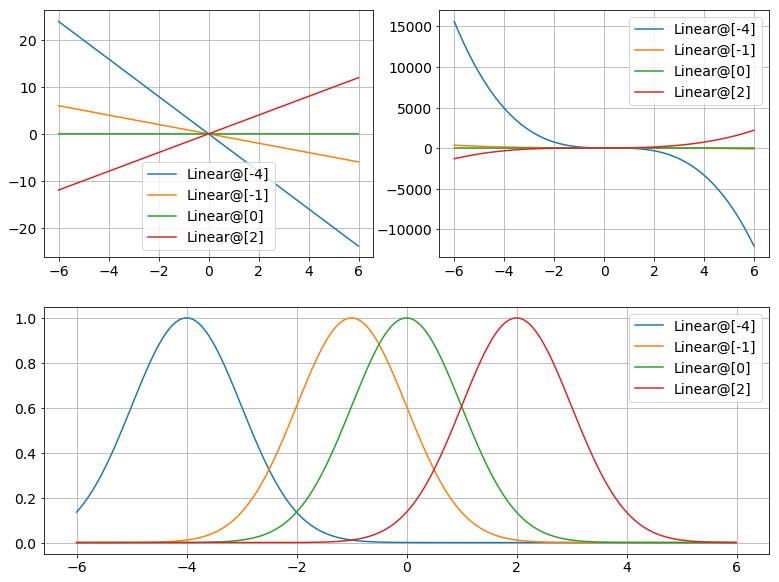

In [3]:
# Plot kernel machine functions
plot_step = .01
xpts = np.arange(-6.0, 6, plot_step).reshape(-1,1)
prototypes = np.array([-4,-1,0,2]).reshape(-1,1)

# Linear kernel
plt.subplot(221)
y = linear_kernel(prototypes, xpts) 
for i, prot in enumerate(prototypes):
    label = 'Linear@{0}'.format(prot)
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.grid(True)

# Polynomial kernel
plt.subplot(222)
y = polynomial_kernel(prototypes, xpts, 1, 3) 
for i, prot in enumerate(prototypes):
    label = 'Linear@{0}'.format(prot)
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.grid(True)

# RBF kernel
plt.subplot(212)
y = RBF_kernel(prototypes, xpts,1) 
for i, prot in enumerate(prototypes):
    label = 'Linear@{0}'.format(prot)
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.grid(True)

plt.show()

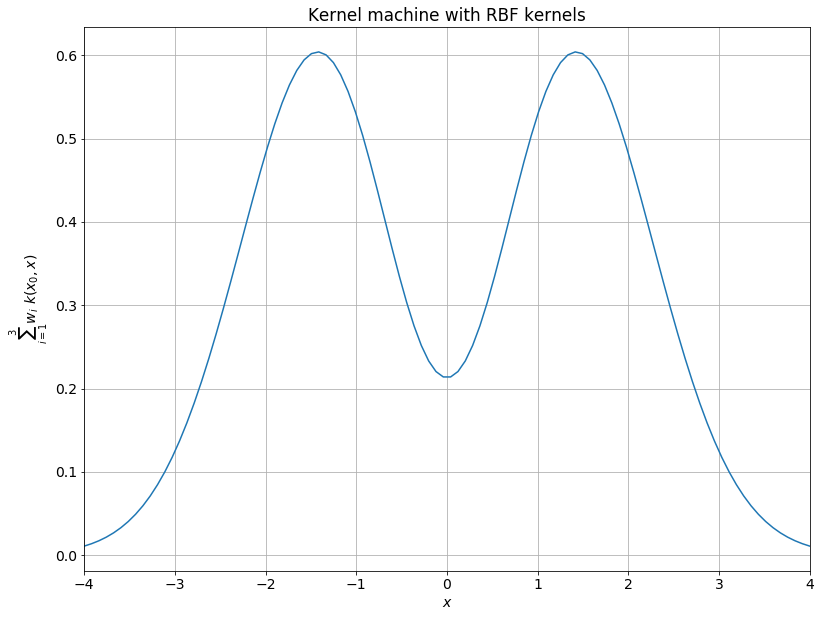

In [4]:
weights = np.array([1,-1,1]).reshape(-1,1)
prototype_points = np.array([-1, 0, 1]).reshape(-1,1)
predictor = Kernel_Machine(functools.partial(RBF_kernel, sigma=1), prototype_points, weights)

xmin = -4
xmax = 4

xpts = np.linspace(xmin, xmax,100).reshape(-1,1)
ypts = predictor.predict(xpts)

plt.plot(xpts, ypts, label=label);
plt.xlim([xmin, xmax]);
plt.grid(True);
plt.title('Kernel machine with RBF kernels');
plt.xlabel(r'$x$', fontsize=14);
plt.ylabel(r'$\sum_{i=1}^3 w_i\ k(x_0, x)$', fontsize=14);

Load train & test data; Convert to column vectors so it generalizes well to data in higher dimensions.

In [5]:
data_train = np.loadtxt(os.path.join('..', 'data', 'krr-train.txt'))
data_test = np.loadtxt(os.path.join('..', 'data', 'krr-test.txt'))
x_train, y_train = data_train[:,0].reshape(-1,1), data_train[:,1].reshape(-1,1)
x_test, y_test = data_test[:,0].reshape(-1,1), data_test[:,1].reshape(-1,1)

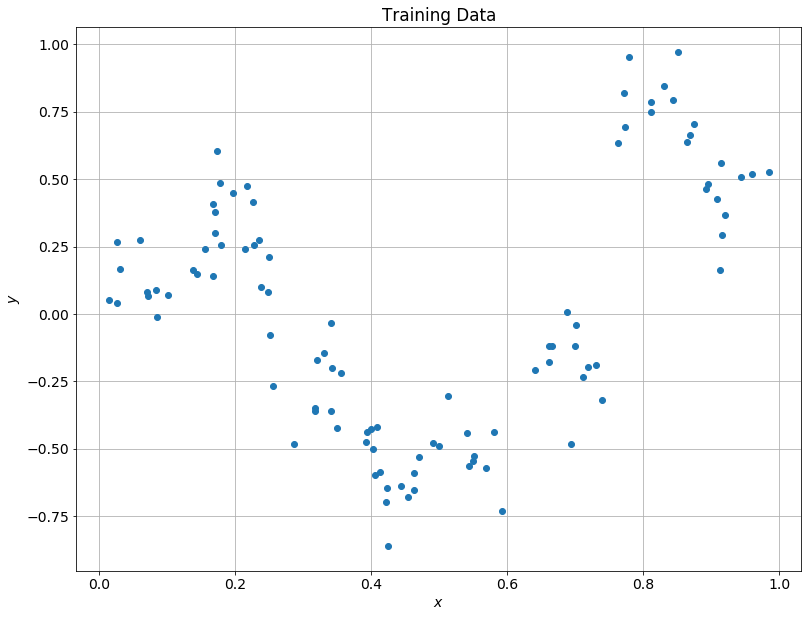

In [6]:
plt.title('Training Data');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.grid(True)

plt.plot(x_train, y_train,'o');

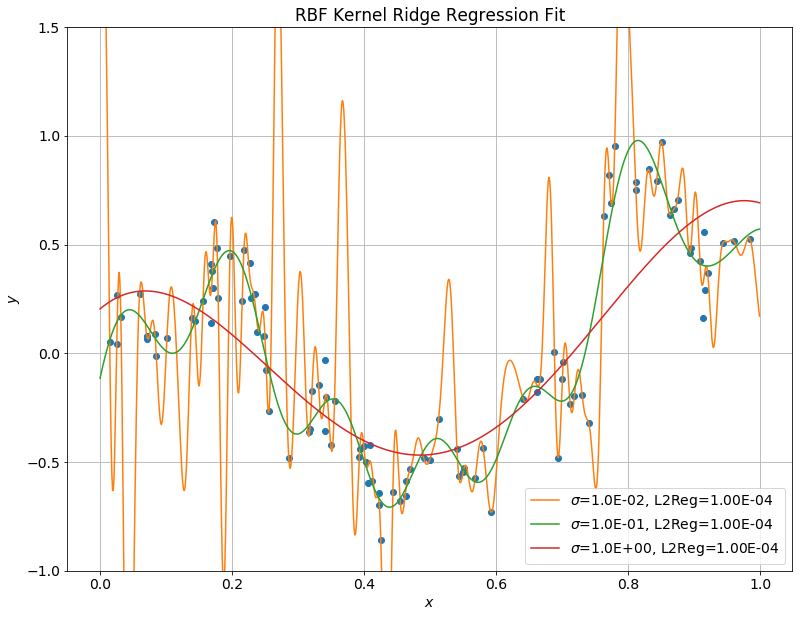

In [7]:
plot_step = .001
xpts = np.arange(0, 1, plot_step).reshape(-1,1)
plt.plot(x_train, y_train, 'o')
l2reg = 0.0001

for sigma in [.01, .1, 1]:
    k = functools.partial(RBF_kernel, sigma=sigma)
    f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
    label = r'$\sigma$={0:.1E}, L2Reg={1:.2E}'.format(sigma, l2reg)
    plt.plot(xpts, f.predict(xpts), label=label)
    
plt.legend(loc = 'best')
plt.ylim(-1,1.5);
plt.title('RBF Kernel Ridge Regression Fit');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

plt.show();

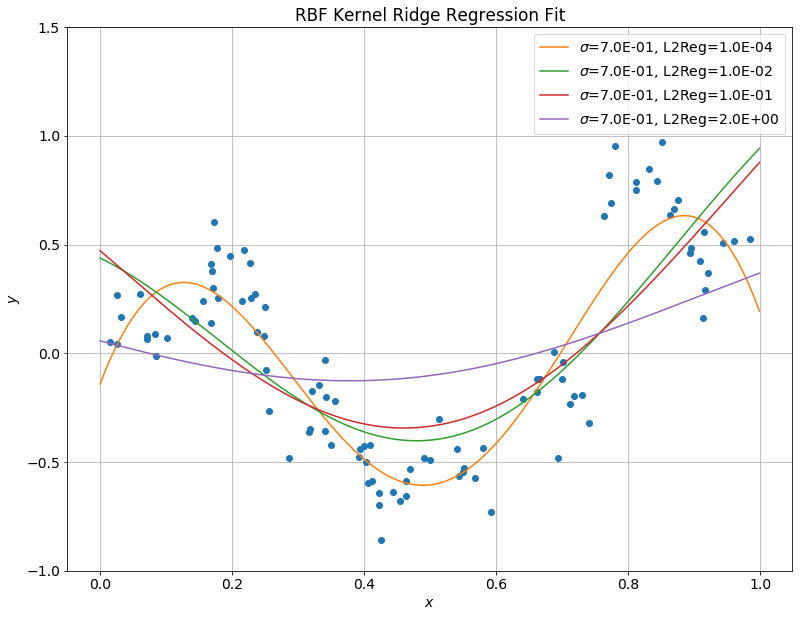

In [8]:
plot_step = .001
xpts = np.arange(0, 1, plot_step).reshape(-1,1)
plt.plot(x_train, y_train, 'o')
sigma = 0.7

for l2reg in [.0001, 0.01, 0.1, 2.0]:
    f = train_kernel_ridge_regression(x_train, y_train, functools.partial(RBF_kernel, sigma=sigma), l2reg=l2reg)
    label = r'$\sigma$={0:.1E}, L2Reg={1:.1E}'.format(sigma, l2reg)
    plt.plot(xpts, f.predict(xpts), label=label)
    
plt.legend(loc = 'best')
plt.ylim(-1, 1.5);
plt.title('RBF Kernel Ridge Regression Fit');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

plt.show();

From the above experiment we can infer that as $\lambda \rightarrow \infty$ that we will approximate with a horizontal line.

In [9]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd
    
test_fold = [-1]*len(x_train) + [0]*len(x_test)   #0 corresponds to test, -1 to train
predefined_split = PredefinedSplit(test_fold=test_fold)

In [10]:
param_grid = [{'kernel': ['RBF'], 'sigma':list(10 ** (-np.linspace(-3, 1, 100))), 'l2reg': 10 ** (np.linspace(-3, 1, 100))},
              {'kernel': ['polynomial'],'offset':[-1, 0, 1], 'degree':[2,3,4,5],'l2reg':10 ** (np.linspace(-3, 1, 100))},
              {'kernel': ['linear'],'l2reg': [10, 1, 0.01]}]

kernel_ridge_regression_estimator = KernelRidgeRegression()
grid = GridSearchCV(kernel_ridge_regression_estimator
                    ,param_grid
                    ,cv = predefined_split
                    ,scoring = make_scorer(mean_squared_error, greater_is_better = False)
                    ,n_jobs = -1
                   )

grid.fit(np.vstack((x_train, x_test)), np.vstack((y_train, y_test))) 

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
       error_score='raise',
       estimator=KernelRidgeRegression(degree=2, kernel='RBF', l2reg=1, offset=1, sigma=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'kernel': ['RBF'], 'sigma': [1000.0, 911.1627561154896, 830.2175681319744, 756.463327554629, 689.2612104349695, 628.0291441834253, 572.236765935022, 521.4008287999684, 475.0810162102798, 432.8761281083057, 394.4206059437656, 359.38136638046257, 327.45491628777285, 298.364724028334, 271....e-03, 1.09750e-03, ..., 9.11163e+00, 1.00000e+01])}, {'kernel': ['linear'], 'l2reg': [10, 1, 0.01]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_squared_error, greater_is_better=False),
       verbose=0)

In [11]:
pd.set_option('display.max_rows', 20)
df = pd.DataFrame(grid.cv_results_)
# Flip sign of score back, because GridSearchCV likes to maximize,
# so it flips the sign of the score if "greater_is_better=FALSE"
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
cols_to_keep = ['param_degree', 'param_kernel', 'param_l2reg', 'param_offset', 
                'param_sigma', 'mean_test_score', 'mean_train_score']
df_toshow = df[cols_to_keep].fillna('-')
df_toshow.sort_values(by=['mean_test_score'])

/Users/chaaland/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/chaaland/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/chaaland/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


,param_degree,param_kernel,param_l2reg,param_offset,param_sigma,mean_test_score,mean_train_score
99,-,RBF,0.001000,-,0.1,0.014894,0.014954
199,-,RBF,0.001097,-,0.1,0.014914,0.015043
299,-,RBF,0.001205,-,0.1,0.014937,0.015138
399,-,RBF,0.001322,-,0.1,0.014963,0.015240
499,-,RBF,0.001451,-,0.1,0.014993,0.015349
599,-,RBF,0.001592,-,0.1,0.015028,0.015466
699,-,RBF,0.001748,-,0.1,0.015068,0.015590
799,-,RBF,0.001918,-,0.1,0.015115,0.015723
899,-,RBF,0.002105,-,0.1,0.015169,0.015864
999,-,RBF,0.002310,-,0.1,0.015232,0.016015


In [12]:
best_rbf = df_toshow[df_toshow['param_kernel'] == 'RBF'].sort_values(by=["mean_test_score"]).head(1)
best_polynomial = df_toshow[df_toshow['param_kernel'] == 'polynomial'].sort_values(by=["mean_test_score"]).head(1)

print('Best Test Error Polynomial: {0:.3E}'.format(best_polynomial.iloc[0]['mean_test_score']))
print('Best Test Error RBF: {0:.3E}'.format(best_rbf.iloc[0]['mean_test_score']))

Best Test Error Polynomial: 3.219E-02
Best Test Error RBF: 1.489E-02


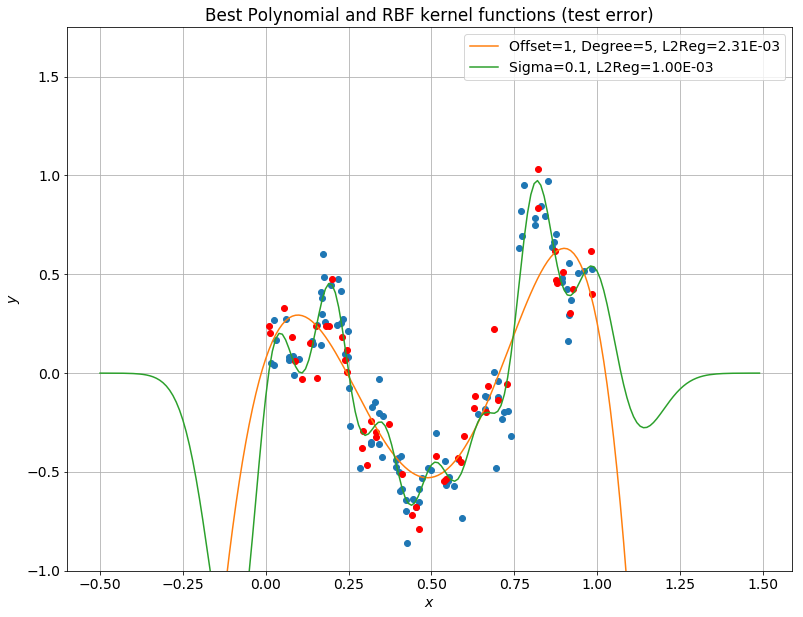

In [13]:
## Plot the best polynomial and RBF fits you found
plot_step = .01
xpts = np.arange(-.5, 1.5, plot_step).reshape(-1,1)
plt.plot(x_train, y_train, 'o')
plt.plot(x_test, y_test, 'ro')

#Plot best polynomial fit
offset = best_polynomial.iloc[0]['param_offset']
degree = best_polynomial.iloc[0]['param_degree']
l2reg = best_polynomial.iloc[0]['param_l2reg']
k = functools.partial(polynomial_kernel, offset=offset, degree=degree)
f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
label = 'Offset={0}, Degree={1}, L2Reg={2:.2E}'.format(offset, degree, l2reg)

plt.plot(xpts, f.predict(xpts), label=label)

#Plot best RBF fit
sigma = best_rbf.iloc[0]['param_sigma']
l2reg= best_rbf.iloc[0]['param_l2reg']
k = functools.partial(RBF_kernel, sigma=sigma)
f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)

label = 'Sigma={0}, L2Reg={1:.2E}'.format(sigma, l2reg)
plt.plot(xpts, f.predict(xpts), label=label);
plt.legend(loc = 'best');
plt.ylim(-1, 1.75);
plt.title('Best Polynomial and RBF kernel functions (test error)');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.show()

In [14]:
# load the training and test sets
data_train = np.loadtxt(os.path.join('..','data','svm-train.txt'))
data_test = np.loadtxt(os.path.join('..','data', 'svm-test.txt'))
x_train, y_train = data_train[:,0:2], data_train[:,2].reshape(-1,1)
x_test, y_test = data_test[:,0:2], data_test[:,2].reshape(-1,1)

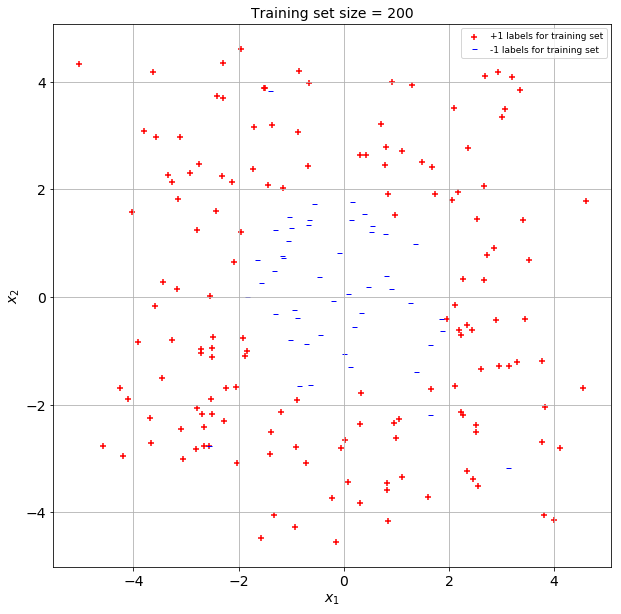

In [15]:
# determine predictions for the training set
yplus = np.ma.masked_where(y_train[:,0] <= 0, y_train[:,0])
xplus = x_train[~np.array(yplus.mask)]
yminus = np.ma.masked_where(y_train[:,0] > 0, y_train[:,0])
xminus = x_train[~np.array(yminus.mask)]

# plot the predictions for the training set
figsize = plt.figaspect(1)
f, (ax) = plt.subplots(1, 1, figsize=figsize) 

pluses = ax.scatter(xplus[:,0], xplus[:,1], marker='+', c='r', label = '+1 labels for training set')
minuses = ax.scatter(xminus[:,0], xminus[:,1], marker=r'$-$', c='b', label = '-1 labels for training set')

ax.set_ylabel(r'$x_2$', fontsize=14);
ax.set_xlabel(r'$x_1$', fontsize=14);
ax.set_title('Training set size = {0}'.format(len(data_train)), fontsize=14);  
ax.axis('tight');
ax.legend(handles=[pluses, minuses], fontsize=9);

plt.show();

In [16]:
test_fold = [-1]*len(x_train) + [0]*len(x_test)   #0 corresponds to test, -1 to train
predefined_split = PredefinedSplit(test_fold=test_fold)

In [17]:
param_grid = [{'kernel': ['RBF'], 'sigma':list(10 ** (np.linspace(-2, 1, 20))), 'l2reg': 10 ** (np.linspace(-2, 1, 20))},
              {'kernel':['polynomial'],'offset':[-1,0,1], 'degree':[2,3,4,5],'l2reg':10 ** (np.linspace(-3, 1, 20)) }]

kernel_pegasos_estimator = KernelPegasos()
grid = GridSearchCV(kernel_pegasos_estimator 
                    ,param_grid
                    ,cv = predefined_split
                    ,scoring = make_scorer(accuracy_score, greater_is_better = True)
                    ,n_jobs = -1  
                   )

# grid.fit(np.vstack((x_train, x_test)), np.vstack(((np.sign(y_train) + 1)//2, (np.sign(y_test) + 1)//2)))
grid.fit(np.vstack((x_train, x_test)), np.vstack((np.sign(y_train), np.sign(y_test))))

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
       error_score='raise',
       estimator=KernelPegasos(degree=2, kernel='RBF', l2reg=1, offset=1, sigma=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'kernel': ['RBF'], 'sigma': [0.01, 0.01438449888287663, 0.0206913808111479, 0.029763514416313176, 0.04281332398719394, 0.06158482110660264, 0.08858667904100823, 0.12742749857031335, 0.18329807108324356, 0.26366508987303583, 0.37926901907322497, 0.5455594781168517, 0.7847599703514611, 1....5.45559e-01, 8.85867e-01,
       1.43845e+00, 2.33572e+00, 3.79269e+00, 6.15848e+00, 1.00000e+01])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(accuracy_score), verbose=0)

In [18]:
pd.set_option('display.max_rows', 20)
df = pd.DataFrame(grid.cv_results_)
cols_to_keep = ['param_degree', 'param_kernel', 'param_l2reg', 'param_offset', 
                'param_sigma', 'mean_test_score', 'mean_train_score']

df_toshow = df[cols_to_keep].fillna('-')
df_toshow.sort_values(by=["mean_test_score"], ascending=False)

/Users/chaaland/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/chaaland/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/chaaland/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


,param_degree,param_kernel,param_l2reg,param_offset,param_sigma,mean_test_score,mean_train_score
420,2,polynomial,0.018330,1,-,0.95875,0.950
11,-,RBF,0.010000,-,0.545559,0.95750,0.965
423,2,polynomial,0.029764,1,-,0.95375,0.950
30,-,RBF,0.014384,-,0.379269,0.95375,0.980
10,-,RBF,0.010000,-,0.379269,0.95375,0.980
290,-,RBF,1.623777,-,0.379269,0.95250,0.970
270,-,RBF,1.128838,-,0.379269,0.95250,0.970
50,-,RBF,0.020691,-,0.379269,0.95250,0.970
31,-,RBF,0.014384,-,0.545559,0.95250,0.965
150,-,RBF,0.127427,-,0.379269,0.95125,0.970


In [19]:
best_rbf = df_toshow[df_toshow['param_kernel'] == 'RBF'].sort_values(by=["mean_test_score"], ascending=False).head(1)
best_polynomial = df_toshow[df_toshow['param_kernel'] == 'polynomial'].sort_values(by=["mean_test_score"], ascending=False).head(1)

print('Best Test Accuracy Polynomial: {0:.3E}'.format(best_polynomial.iloc[0]['mean_test_score']))
print('Best Test Accuracy RBF: {0:.3E}'.format(best_rbf.iloc[0]['mean_test_score']))

Best Test Accuracy Polynomial: 9.587E-01
Best Test Accuracy RBF: 9.575E-01


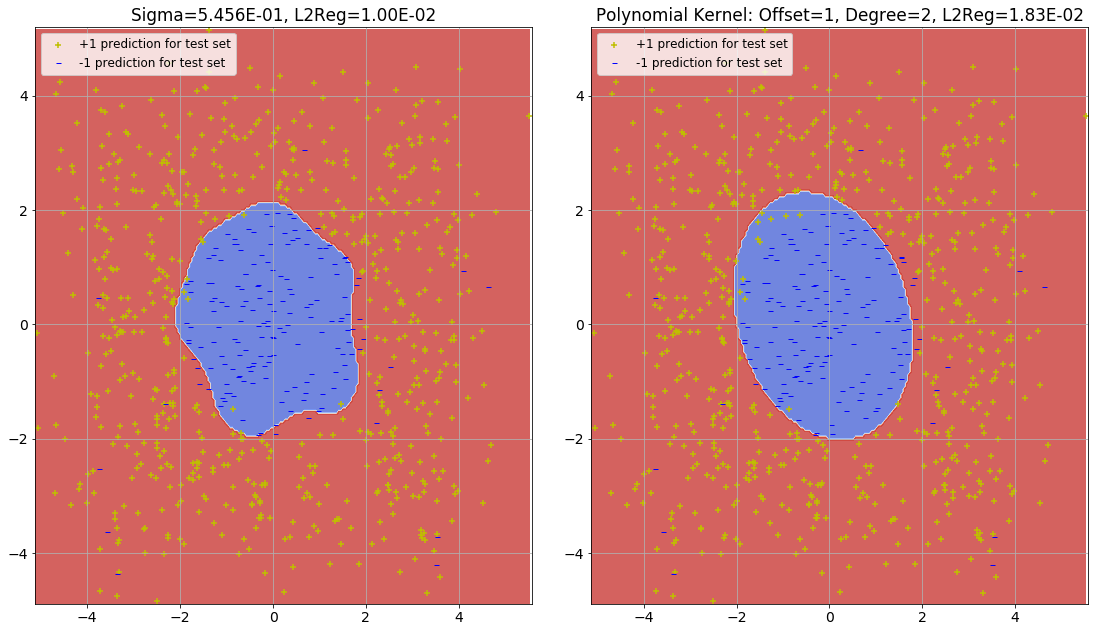

In [20]:
#determine the decision regions for the predictions
h = 0.05
x1_min = min(x_test[:, 0]) - h
x1_max= max(x_test[:, 0]) + h
x2_min = min(x_test[:, 1]) - h
x2_max= max(x_test[:, 1]) + h
xx, yy = np.meshgrid(np.arange(x1_min, x1_max, h),
                     np.arange(x2_min, x2_max, h))

poly_offset = best_polynomial.iloc[0]['param_offset']
poly_degree = best_polynomial.iloc[0]['param_degree']
poly_l2reg = best_polynomial.iloc[0]['param_l2reg']

rbf_sigma = best_rbf.iloc[0]['param_sigma']
rbf_l2reg = best_rbf.iloc[0]['param_l2reg']

rbf_pegasos = KernelPegasos(kernel='RBF', sigma=rbf_sigma, l2reg=rbf_l2reg)
rbf_pegasos.fit(x_train, np.sign(y_train), 100)

poly_pegasos = KernelPegasos(kernel='polynomial', degree=poly_degree, offset=poly_offset, l2reg=poly_l2reg)
poly_pegasos.fit(x_train, np.sign(y_train), 100)

Z_poly = poly_pegasos.predict(np.c_[xx.ravel(), yy.ravel()])
Z_poly = Z_poly.reshape(xx.shape)

Z_rbf = rbf_pegasos.predict(np.c_[xx.ravel(), yy.ravel()])
Z_rbf = Z_rbf.reshape(xx.shape)

yplus_true = np.ma.masked_where(y_test <= 0, y_test).squeeze()
xplus_true = x_test[~np.array(yplus_true.mask)]
yminus_true = np.ma.masked_where(y_test > 0, y_test).squeeze()
xminus_true = x_test[~np.array(yminus_true.mask)]

plt.figure(figsize=(16,9));

# plot the learned boundary and the predictions for the test set
plt.subplot(121)
plt.contourf(xx, yy, Z_rbf, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(xplus_true[:, 0], xplus_true[:, 1], marker='+', c='y', label = '+1 prediction for test set')
plt.scatter(xminus_true[:, 0], xminus_true[:, 1], marker=r'$-$', c='b', label = '-1 prediction for test set')
plt.xlim(x1_min, x1_max);
plt.ylim(x2_min, x2_max);
plt.legend(fontsize=12);
title_str = 'Sigma={0:.3E}, L2Reg={1:.2E}'.format(rbf_sigma, rbf_l2reg)
plt.title(title_str);

plt.subplot(122)
plt.contourf(xx, yy, Z_poly, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(xplus_true[:, 0], xplus_true[:, 1], marker='+', c='y', label = '+1 prediction for test set')
plt.scatter(xminus_true[:, 0], xminus_true[:, 1], marker=r'$-$', c='b', label = '-1 prediction for test set')
plt.xlim(x1_min, x1_max);
plt.ylim(x2_min, x2_max);
plt.legend(fontsize=12);
title_str = 'Polynomial Kernel: Offset={0}, Degree={1}, L2Reg={2:.2E}'.format(poly_offset, poly_degree, poly_l2reg)
plt.title(title_str);

plt.tight_layout()
plt.show()

# Problem 7 

We know that if $m_0 = \mathbf{proj}_M(x)$ then $x-m_0 \in M^{\perp}$. To show that $||m_0|| = ||x||$ if and only if $m_0 = x$ we can use the pythagorean theorem
$$
\begin{align*}
||x||^2 &= ||m_0||^2 + ||x-m_0||^2\\
\implies 0 &= ||x-m_0||^2 \qquad // \ ||x|| = ||m_0||\\
\implies x &= m_0 \qquad //\ \text{norm is PSD}
\end{align*}
$$

Consider the objective function
$$J(w) = R(||w||) + L\left(\langle w, \psi(x_1)\rangle, \ldots,\langle w, \psi(x_n)\rangle\right)$$

Now suppose we have $z \in \mathbf{span}(\psi(x_1), \ldots,\psi(x_n))$ and $p \in \mathbf{span}(\psi(x_1), \ldots,\psi(x_n))^\perp$ and $p\ne 0$. Given $R$ is strictly increasing we can show that any minimizer of $J$ must be in the span of the feature vectors.

First note that $||z|| < ||z + p||$ by the Pythagorean theorem. Next, note that $\langle z, \psi(x_1)\rangle = \langle z+p, \psi(x_1)\rangle$ due to the orthogonality of $p$ to all feature vectors. From this it immediately follows that $J(z+p) > J(z)$ which demonstrates that for any feasible point, we can always decrease the objective by projecting it onto the span of the feature vectors. Specifically, it means the minimizer of $J(w)$ **must** have the form

$$w^\star = \sum_{i=1}^n \alpha_i \psi(x_i)$$

Still supposing $R : \mathbf{R}_+ \rightarrow \mathbf{R}$ is a strictly increasing function and adding the condition that $L:\mathbf{R}^n \rightarrow \mathbf{R}$ is convex, then we can show the objective $J$ is also convex. We can define 
$$
\Psi(X) = 
\begin{bmatrix}
- & \psi(x_1)^T & -\\
- & \psi(x_2)^T & -\\
& \vdots &\\
- & \psi(x_n)^T & -\\
\end{bmatrix} \in \mathbf{R}^{n \times d}
$$

This allows us to write the objective as

$$J(w) = R(||w||) + L(\Psi(X)w)$$

where $R)$ is convex in $w$ since the norm is conex and the function is increasing. $L(\Psi(X))$ is also convex since it is the composition of a convex function with an affine one. Convexity of $L$ ensures a solution is the _only_ solution

# Appendix A

If $\Sigma \succeq 0$ with eigenvector $v$ with eigenvalue $\sigma$ then 
$$
\begin{align*}
v^T\Sigma v &\ge 0 \qquad //\text{definition of PSD} \\
v^T (\sigma v) &\ge 0 \\
\sigma ||v||^2 &\ge 0\\
\sigma &\ge 0
\end{align*}
$$

This shows that any eigenvector of a PSD matrix will be nonnegative

If $\Sigma \succeq 0 \implies \Sigma = BB^T$. This follows from the fact that a symmetric matrix has eigenvalue decomposition $\Sigma = Q\mathbf{diag}(\sigma_1, \sigma_2, \ldots, \sigma_n)Q^T$. Since all the eigenvalues are nonnegative we have $\Sigma = QD^{1/2}D^{T/2}Q^T$ where $D^{1/2} = \mathbf{diag}\left(\sqrt{\sigma_1}, \sqrt{\sigma_2}, \ldots, \sqrt{\sigma_n}\right)$. We can identify $B= QD^{1/2}$

If $\Sigma = BB^T \implies \Sigma\succeq 0$. This follows immediately from the definition of PSD

$$
\begin{align*}
x^T\Sigma x &= x^TBB^Tx\\
  &= (Bx)^TB^Tx\\
  &= ||Bx||^2 \qquad //\ x^Tx = ||x||^2\\
  &\ge 0
\end{align*}
$$

Therefore $\Sigma \succeq 0$ if and only if it has a square root.

# Appendix B

If $\Sigma \succ 0$ with eigenvector $v$ and eigenvalue $\sigma$ the 
$$
\begin{align*}
    v^T\Sigma v > 0  \qquad //\ \text{def of positive definite}\\
    v^T(\sigma v) > 0\\
    \sigma||v||^2 > 0\\
    \sigma > 0
\end{align*}
$$

By the spectral theorem we can write $\Sigma = QDQ^T$ where $Q^TQ = I$ and $D = \mathbf{diag}(\sigma_1,\sigma_2,\ldots,\sigma_n)$. We can trivially verify that $QD^{-1}Q^T$ is the inverse of $\Sigma$ since 

$$
\begin{align*}
    (QD^{-1}Q^T)\Sigma &= (QD^{-1}Q^T)QDQ^T \\
    &= QD^{-1}DQ^T\\
    &=QQ^T\\
    &= I \qquad \blacksquare
\end{align*}
$$

If $M \succeq 0$ and $\lambda > 0$ then $M+\lambda I \succ 0$.

$$
\begin{align*}
  x^T(M+\lambda I)x &= x^TMx +\lambda ||x||^2\\
  &\ge \lambda ||x||^2 \\
  & > 0      \qquad \forall x \ne 0
\end{align*}
$$

If $M \succeq 0$ and $N\succ 0$ then $M+N \succ 0$ which follows immediately form the definition

$$
\begin{align*}
    x^T(M+N)x &= x^TMx + x^TNx\\
    &\ge x^TNx\\
    &> 0 \qquad \forall x \ne 0
\end{align*}
$$